In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Steg for prosjektet---

In [72]:
# Load the movies data with correct column indices and drop unnecessary ones afterward
movies = pd.read_csv("/kaggle/input/ml-100k/u.item", sep='|', encoding="ISO-8859-1", header=None,
                     names=["movie_id", "movie_title", "release_date", "video_release_date", "IMDb_URL",
                            "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime",
                            "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery",
                            "Romance", "Sci-Fi", "Thriller", "War", "Western"])

movies.drop(columns=["video_release_date", "IMDb_URL", "unknown"], inplace=True)

# Convert release_date to datetime to support year-based calculations
movies['release_date'] = pd.to_datetime(movies['release_date'], format='%d-%b-%Y', errors='coerce')

movies.head()

,movie_id,movie_title,release_date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1995-01-01,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),1995-01-01,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),1995-01-01,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),1995-01-01,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),1995-01-01,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


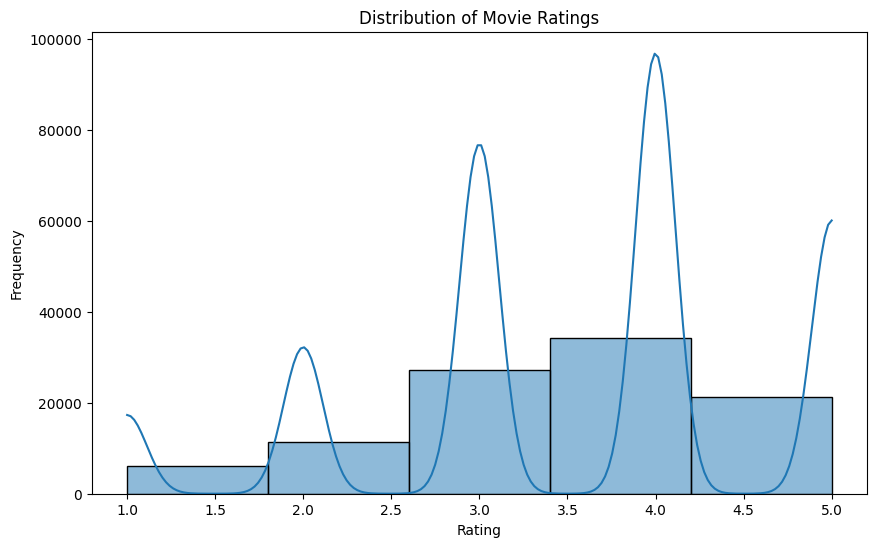

In [73]:
# Plot distribution of movie ratings
plt.figure(figsize=(10, 6))
sns.histplot(ratings['rating'], bins=5, kde=True)
plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

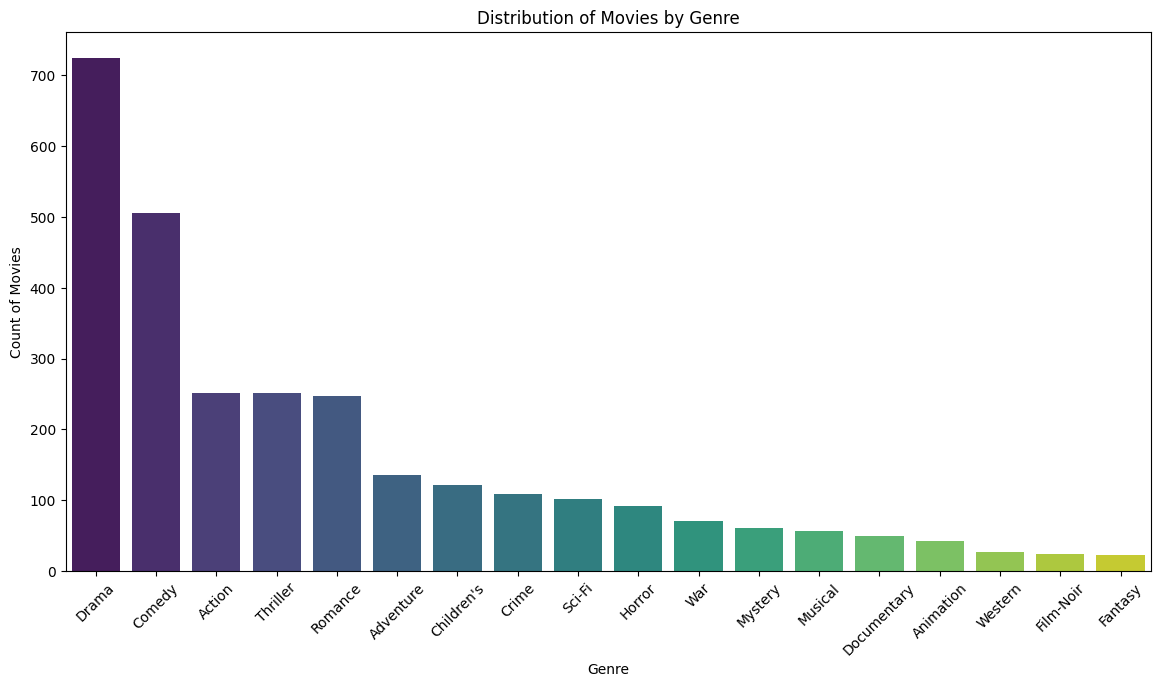

In [74]:
# Plot count of movies in each genre
genre_columns = ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 
                 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 
                 'Sci-Fi', 'Thriller', 'War', 'Western']
genre_counts = movies[genre_columns].sum().sort_values(ascending=False)

plt.figure(figsize=(14, 7))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="viridis")
plt.title("Distribution of Movies by Genre")
plt.xlabel("Genre")
plt.ylabel("Count of Movies")
plt.xticks(rotation=45)
plt.show()


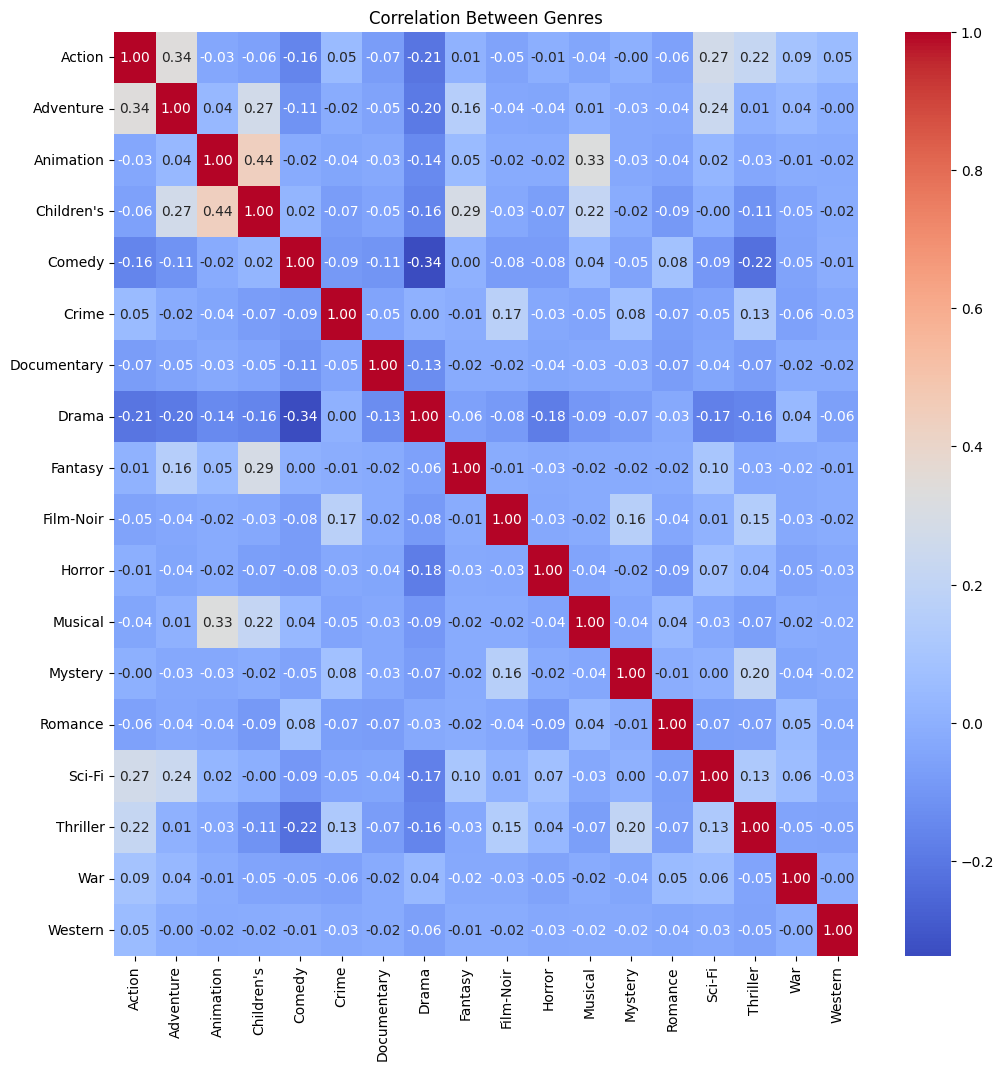

In [75]:
# Plot a correlation heatmap for genres to show inter-genre relationships
plt.figure(figsize=(12, 12))
sns.heatmap(movies[genre_columns].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Between Genres")
plt.show()

In [76]:
# Merge ratings with movies to include genre information in the ratings dataset
ratings_movies = pd.merge(ratings, movies, left_on='item_id', right_on='movie_id')
ratings_movies.head()
# Scale the ratings to normalize the values for model input
scaler = MinMaxScaler()
ratings_movies['scaled_rating'] = scaler.fit_transform(ratings_movies[['rating']])
ratings_movies.head()

,user_id,item_id,rating,timestamp,movie_id,movie_title,release_date,Action,Adventure,Animation,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,scaled_rating
0,196,242,3,881250949,242,Kolya (1996),1997-01-24,0,0,0,...,0,0,0,0,0,0,0,0,0,0.50
1,186,302,3,891717742,302,L.A. Confidential (1997),1997-01-01,0,0,0,...,1,0,0,1,0,0,1,0,0,0.50
2,22,377,1,878887116,377,Heavyweights (1994),1994-01-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0.00
3,244,51,2,880606923,51,Legends of the Fall (1994),1994-01-01,0,0,0,...,0,0,0,0,1,0,0,1,1,0.25
4,166,346,1,886397596,346,Jackie Brown (1997),1997-01-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0.00


In [77]:
# Create the user-item matrix
user_item_matrix = ratings.pivot(index='user_id', columns='item_id', values='rating').fillna(0)

# Calculate the correlation matrix to determine similarities between movies
movie_similarity_df = user_item_matrix.corr(method='pearson')

In [78]:
# Split data into train and test sets for validation purposes
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)
train_data.head()

,user_id,item_id,rating,timestamp
75220,807,1411,1,893082619
48955,474,659,5,887925187
44966,463,268,4,877384940
13568,139,286,4,879537844
92727,621,751,4,883799651


In [79]:
# Compute the correlation matrix to identify relationships between movies based on user ratings
movie_corr_matrix = user_item_matrix.corr()
movie_corr_matrix.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
item_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.234595,0.193362,0.226213,0.128840,0.015113,0.347354,0.254490,0.209502,0.104655,...,0.018215,-0.029676,-0.029676,-0.029676,0.018215,-0.029676,-0.029676,-0.029676,0.034179,0.034179
2,0.234595,1.000000,0.190649,0.409044,0.240712,0.030062,0.220022,0.206020,0.077894,0.072906,...,-0.012451,-0.012451,-0.012451,-0.012451,-0.012451,-0.012451,-0.012451,-0.012451,0.071415,0.071415
3,0.193362,0.190649,1.000000,0.227849,0.141368,0.065347,0.258855,0.078636,0.146181,0.079608,...,-0.009764,-0.009764,-0.009764,-0.009764,0.023964,-0.009764,-0.009764,-0.009764,-0.009764,0.091421
4,0.226213,0.409044,0.227849,1.000000,0.237298,0.021878,0.295489,0.352800,0.229922,0.138220,...,-0.016619,-0.016619,0.088984,0.088984,0.025622,-0.016619,-0.016619,-0.016619,0.046743,0.067863
5,0.128840,0.240712,0.141368,0.237298,1.000000,-0.008594,0.205289,0.145866,0.142541,-0.033746,...,-0.009889,-0.009889,-0.009889,-0.009889,-0.009889,-0.009889,-0.009889,-0.009889,-0.009889,0.088618


In [80]:
def recommend_movies_new_user(genres=[], movies_liked=[], year=None, num_recommendations=5):
    """
    Recommend movies to a new user based on their preferred genres, liked movies, and optional year preferences.
    :param genres: List of genres the user prefers.
    :param movies_liked: List of movies the user likes.
    :param year: Year around which the user prefers movies (optional).
    :param num_recommendations: Number of movies to recommend.
    :return: List of recommended movie titles.
    """
    # Filter movies based on genre preferences if provided
    if genres:
        genre_mask = movies[genres].sum(axis=1) > 0
        filtered_movies = movies[genre_mask]
    else:
        filtered_movies = movies

    # Calculate a genre similarity score for each movie
    genre_score = filtered_movies[genres].sum(axis=1) if genres else pd.Series([0] * len(filtered_movies))

    # Get IDs for movies liked by the user
    liked_movie_ids = movies[movies['movie_title'].isin(movies_liked)]['movie_id']
    
    # Calculate movie similarity scores based on genres for liked movies
    similarity_scores = pd.Series([0] * len(filtered_movies), index=filtered_movies.index)
    
    for movie_id in liked_movie_ids:
        # Genre similarity contribution from liked movies
        liked_movie_genres = movies.loc[movies['movie_id'] == movie_id, genres].values.flatten()
        movie_similarity = filtered_movies[genres].dot(liked_movie_genres)
        
        # Sum similarity scores for each liked movie
        similarity_scores += movie_similarity

    # Normalize similarity scores if necessary
    similarity_scores = similarity_scores / similarity_scores.max()

    # Combine genre score and similarity score with weights (genre_weight = 0.5 as default)
    genre_weight = 0.5
    combined_score = genre_weight * genre_score + (1 - genre_weight) * similarity_scores

    # Year-based scoring if the year is provided
    if year is not None:
        # Convert release_date to datetime
        movies['release_date'] = pd.to_datetime(movies['release_date'], errors='coerce')
        filtered_movies['release_year'] = movies['release_date'].dt.year

        # Calculate year proximity score (movies closer to the given year get higher scores)
        filtered_movies['year_proximity_score'] = 1 / (1 + abs(filtered_movies['release_year'] - year))
        
        # Normalize year proximity score
        filtered_movies['year_proximity_score'] = filtered_movies['year_proximity_score'] / filtered_movies['year_proximity_score'].max()

        # Combine year proximity with combined score (adjust weight to balance)
        year_weight = 0.3  # Adjust this weight to control the influence of year proximity
        final_scores = (1 - year_weight) * combined_score + year_weight * filtered_movies['year_proximity_score']
    else:
        final_scores = combined_score

    # Sort movies based on the final scores and recommend the top N movies
    filtered_movies['final_score'] = final_scores
    recommendations = filtered_movies.sort_values(by='final_score', ascending=False)
    # Exclude liked movies
    recommendations = recommendations[~recommendations['movie_id'].isin(liked_movie_ids)]  # Exclude liked movies

    return recommendations['movie_title'].head(num_recommendations).tolist()

# Example usage with and without the year parameter
print(recommend_movies_new_user(genres=["Action", "Adventure"], movies_liked=["Apollo 13 (1995)", "2001: A Space Odyssey (1968)"], year=1990, num_recommendations=5))
print(recommend_movies_new_user(genres=["Comedy"], movies_liked=["Ted 2 (2015)"], num_recommendations=5))


['Star Trek VI: The Undiscovered Country (1991)', 'Star Trek V: The Final Frontier (1989)', 'Abyss, The (1989)', 'Batman (1989)', 'Indiana Jones and the Last Crusade (1989)']
['Toy Story (1995)', 'Get Shorty (1995)', 'Babe (1995)', 'Mighty Aphrodite (1995)', 'French Twist (Gazon maudit) (1995)']


/tmp/ipykernel_30/2791577363.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_movies['release_year'] = movies['release_date'].dt.year
/tmp/ipykernel_30/2791577363.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_movies['year_proximity_score'] = 1 / (1 + abs(filtered_movies['release_year'] - year))
/tmp/ipykernel_30/2791577363.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [81]:
# Evaluation function to test the enhanced recommender system
def evaluate_recommender(test_cases, num_recommendations=5):

    for i, test_case in enumerate(test_cases):
        movies_watched = test_case.get("movies_watched", [])
        genres = test_case.get("genres", [])
        
        # Get recommendations based on movies watched and genres
        recommendations = recommend_movies(movies_watched, genres=genres, num_recommendations=num_recommendations)
        
        # Print the recommendations
        print(f"Test Case {i+1} - Movies Watched: {movies_watched}, Genres: {genres}")
        print(f"Recommendations: {recommendations}\n")

# Define test cases with multiple movies and genres
test_cases = [

    {
        "movies_watched": ["Die Hard (1988)"],
        "genres": ["Thriller"]
    },
    {
        "movies_watched": ["Forrest Gump (1994)", "La La Land (2016)"],
        "genres": ["Drama", "Romance"]
    },
    {
        "movies_watched": ["Star Wars (1977)", "Dune (2021"],
        "genres": ["Adventure", "Sci-Fi"]
    },
    {
        "movies_watched": ["Jurassic Park (1993)"],
        "genres": []
    }
]

evaluate_recommender(test_cases)


NameError: name 'user_genre_preferences' is not defined